# XG Boost and Prophet model for Demand Forecasting

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Load data
df = pd.read_csv("sales_data.csv")

# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'],  infer_datetime_format=True)

# Select one item for visualization later
item_to_plot = df['item'].unique()[0]


<ipython-input-7-ea1b46c0c046>:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'],  infer_datetime_format=True)


In [9]:

prophet_forecasts = {}

for item in df['item'].unique()[:10]:
    item_df = df[df['item'] == item][['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})

    model = Prophet()
    model.fit(item_df)

    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

    prophet_forecasts[item] = forecast[['ds', 'yhat']].rename(columns={'yhat': 'prophet_pred'})


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj54sutjf/lwuoc820.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj54sutjf/9__ji3_g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41437', 'data', 'file=/tmp/tmpj54sutjf/lwuoc820.json', 'init=/tmp/tmpj54sutjf/9__ji3_g.json', 'output', 'file=/tmp/tmpj54sutjf/prophet_modelvrca6a0h/prophet_model-20250226051119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:11:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:11:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj5

In [10]:

item_df = df[df['item'] == item_to_plot].rename(columns={'date': 'ds'})
forecast_df = prophet_forecasts[item_to_plot]

merged_df = pd.merge(item_df, forecast_df, on='ds', how='left')
merged_df.dropna(inplace=True)

X = merged_df[['prophet_pred']]
y = merged_df['sales']

xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100)
xgb_model.fit(X, y)

merged_df['xgb_pred'] = xgb_model.predict(X)


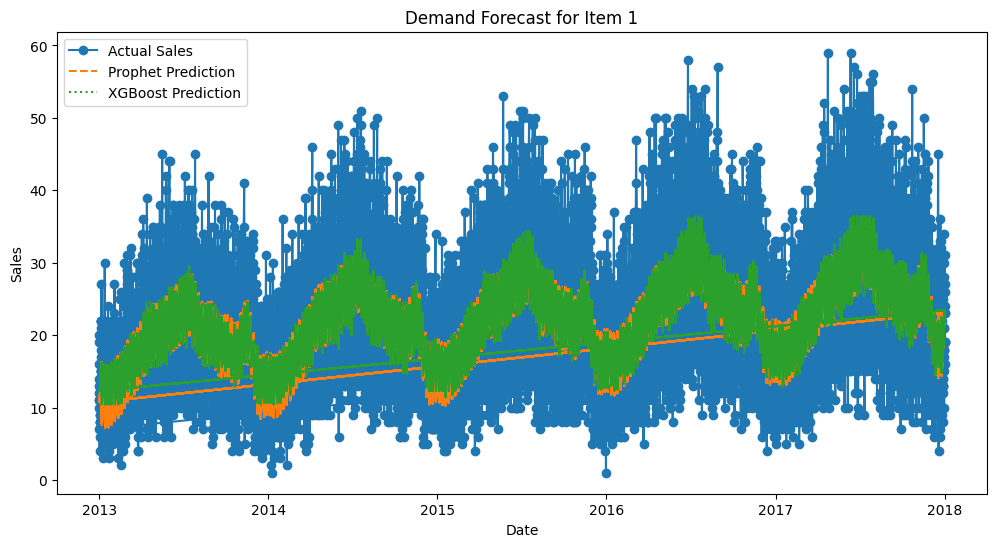

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['ds'], merged_df['sales'], label="Actual Sales", marker='o')
plt.plot(merged_df['ds'], merged_df['prophet_pred'], label="Prophet Prediction", linestyle="dashed")
plt.plot(merged_df['ds'], merged_df['xgb_pred'], label="XGBoost Prediction", linestyle="dotted")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title(f"Demand Forecast for Item {item_to_plot}")
plt.legend()
plt.show()


In [13]:
"The plot suggests that while Prophet and XGBoost are capturing the overall trend, they might not be modeling the short-term fluctuations accurately yet."

'The plot suggests that while Prophet and XGBoost are capturing the overall trend, they might not be modeling the short-term fluctuations accurately yet.'